In [1]:
## Loading samples, store data in dataframe
import pandas as pd
%run data_prep.ipynb

('top_xl_7', 'antitop_xl_7', 'cosTheta1r_7', 'cosTheta2r_7', 'rmin0_7', 'rmin1_7', 'sT_met_7', 'MT2r_7', 'weight_7', 'channel_7', 'MCTruth_MP_7', 'MCTruth_WP_7')
('top_xl_7', 'antitop_xl_7', 'cosTheta1r_7', 'cosTheta2r_7', 'rmin0_7', 'rmin1_7', 'sT_met_7', 'MT2r_7', 'weight_7', 'channel_7', 'MCTruth_MP_7', 'MCTruth_WP_7')


In [2]:
import math
seed = 1234
np.random.seed(seed)

df = {}
VARS = [ 'sT_met_7', 'rmin0_7', 'rmin1_7','top_xl_7','antitop_xl_7','cosTheta1r_7','cosTheta2r_7']
BINS = {'sT_met_7':50, 'rmin0_7':100, 'rmin1_7':100,'top_xl_7':40,'antitop_xl_7':40, 'cosTheta1r_7':40, 'cosTheta2r_7':40,}

for k in filename.keys():
    df[k] = pd.DataFrame(params[k],columns=VARS)
    df[k] = df[k][df[k]['sT_met_7'] >=0]

df[('bkg','mm')]['label'] = np.zeros(len(df[('bkg','mm')]))
df[('sig','mm')]['label'] = np.ones(len(df[('sig','mm')]))

In [3]:
## DNN architecture 
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import regularizers
from IPython.display import Image

Using TensorFlow backend.


7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 56)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 56)                3192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1596      
_________________________________________________________________
dropout_3 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 29        
Total pa

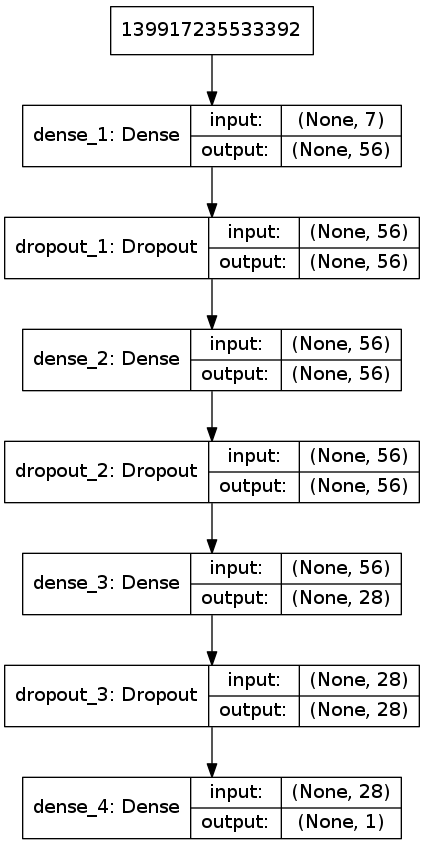

In [5]:
# Case 4: 2 layers, nodes = eight* features  + l2 regularized
# 3rd layer, nodes = four* features  + l2 regularized

NDIM = len(VARS)
print(NDIM)
model_3l = Sequential()

model_3l.add(Dense(NDIM*8, activation = "relu", input_shape=(NDIM, ), kernel_regularizer= regularizers.l2(0.01)))
model_3l.add(Dropout(0.2, noise_shape=None, seed=None))
model_3l.add(Dense(NDIM*8, activation = "relu", kernel_regularizer= regularizers.l2(0.01)))
model_3l.add(Dropout(0.2, noise_shape=None, seed=None))
model_3l.add(Dense(NDIM*4, activation = "relu", kernel_regularizer= regularizers.l2(0.01)))
model_3l.add(Dropout(0.2, noise_shape=None, seed=None)) 
model_3l.add(Dense(1, activation = "sigmoid"))


# compile the model
model_3l.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3l.summary()
plot_model(model_3l, to_file='model_3l_plot.png',
           show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_3l_plot.png')

In [6]:
#sample n (n=number of signal events) from bkg 
from sklearn.model_selection import train_test_split

df_sampled_bkg = df[('bkg','mm')].sample(n=df[('sig','mm')].shape[0], random_state=1)
df_all = pd.DataFrame([])
df_all = pd.concat([df[('sig','mm')],df_sampled_bkg])
print df[('sig','mm')].shape
print df_sampled_bkg.shape
print df_all.shape

df_all.sample(frac=1)
np.random.seed(4)
np.random.shuffle(df_all.values)

(951, 8)
(951, 8)
(1902, 8)


In [7]:
X = df_all.iloc[:,0:len(VARS)] #Predictors
Y = df_all.iloc[:,len(VARS)]   #Outcomes


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print type(X_test)
print type(X)
print(X_train.shape)
print(X_test.shape)
print(X_train.shape[0]/float(X_train.shape[0]+X_test.shape[0]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1521, 7)
(381, 7)
0.799684542587


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import dump, load
from sklearn.externals import joblib

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print("scaling operator mean" , scaler.mean_)

scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

scaler_total = joblib.load(scaler_filename) 
X = scaler_total.transform(X)

print X_train.mean(axis=0) 
print X_test.mean(axis=0) 
print X.mean(axis=0) 

print X_train.shape

('scaling operator mean', array([ 1.34955291e+03,  5.73492352e-01,  6.11085776e-01,  6.04775244e-01,
        5.97407104e-01, -1.69126488e-01, -1.45735232e-01]))
[ 6.54016982e-17  1.98540870e-17  8.05842353e-17 -1.44818046e-16
 -1.86861995e-17 -1.98540870e-17 -2.33577494e-18]
[-2.31928529e-02 -3.12688569e-05 -4.03097928e-02  4.36505011e-02
  3.55373196e-02  3.52526397e-02  2.14395854e-02]
[-4.64588695e-03 -6.26363537e-06 -8.07467458e-03  8.74387010e-03
  7.11867443e-03  7.06164865e-03  4.29468036e-03]
(1521, 7)


In [10]:
# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)
# Train classifier
history_3l = model_3l.fit(X_train, 
                          Y_train, 
                          epochs=400, 
                          batch_size=1024, 
                          verbose=0, # switch to 1 for more verbosity 
                          callbacks=[early_stopping, model_checkpoint], 
                          validation_split=0.25)

Text(0,0.5,'loss')

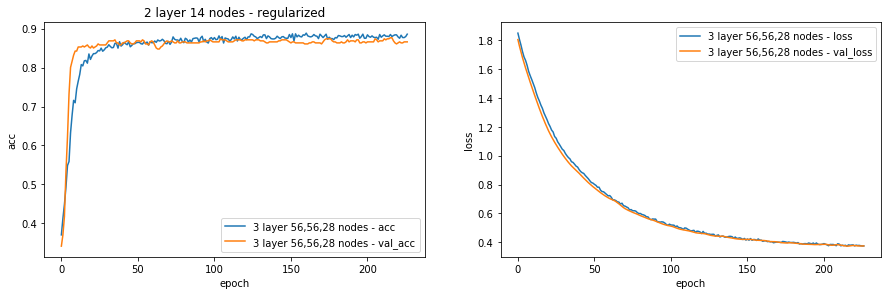

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(15,25))

#MODEL 1
# plot accuracy vs epoch
ax = plt.subplot(5, 2, 1)
ax.plot(history_3l.history['acc'], label='3 layer 56,56,28 nodes - acc')
ax.plot(history_3l.history['val_acc'], label='3 layer 56,56,28 nodes - val_acc')
ax.legend(loc="lower right")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('2 layer 14 nodes - regularized'); 

# plot loss vs epoch
ax = plt.subplot(5, 2, 2)
ax.plot(history_3l.history['loss'], label='3 layer 56,56,28 nodes - loss')
ax.plot(history_3l.history['val_loss'], label='3 layer 56,56,28 nodes - val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

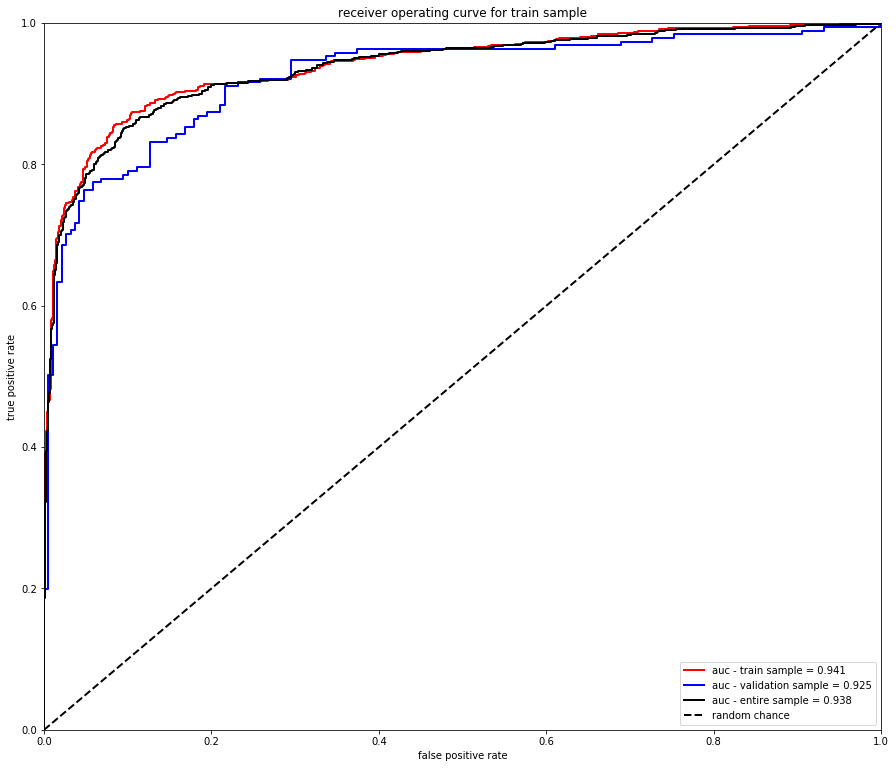

In [14]:
plt.figure(figsize=(15,13))

# Plot ROC for train sample
from sklearn.metrics import roc_curve, auc
Y_predict_3l_train = model_3l.predict(X_train)
Y_predict_3l_test = model_3l.predict(X_test)
Y_predict_3l = model_3l.predict(X)

fpr_3l_train , tpr_3l_train , thresholds_3l_train  = roc_curve(Y_train, Y_predict_3l_train )
fpr_3l_test , tpr_3l_test , thresholds_3l_test  = roc_curve(Y_test, Y_predict_3l_test )
fpr_3l , tpr_3l , thresholds_3l  = roc_curve(Y, Y_predict_3l )

roc_auc_3l_train  = auc(fpr_3l_train , tpr_3l_train )
roc_auc_3l_test  = auc(fpr_3l_test , tpr_3l_test )
roc_auc_3l  = auc(fpr_3l , tpr_3l )


ax = plt.subplot(1, 1, 1)
ax.plot(fpr_3l_train , tpr_3l_train , lw=2, color='red', label='auc - train sample = %.3f' 
        % (roc_auc_3l_train ))
ax.plot(fpr_3l_test , tpr_3l_test , lw=2, color='blue', label='auc - validation sample = %.3f' 
        % (roc_auc_3l_test ))
ax.plot(fpr_3l , tpr_3l , lw=2, color='black', label='auc - entire sample = %.3f' 
        % (roc_auc_3l ))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve for train sample')
ax.legend(loc="lower right")


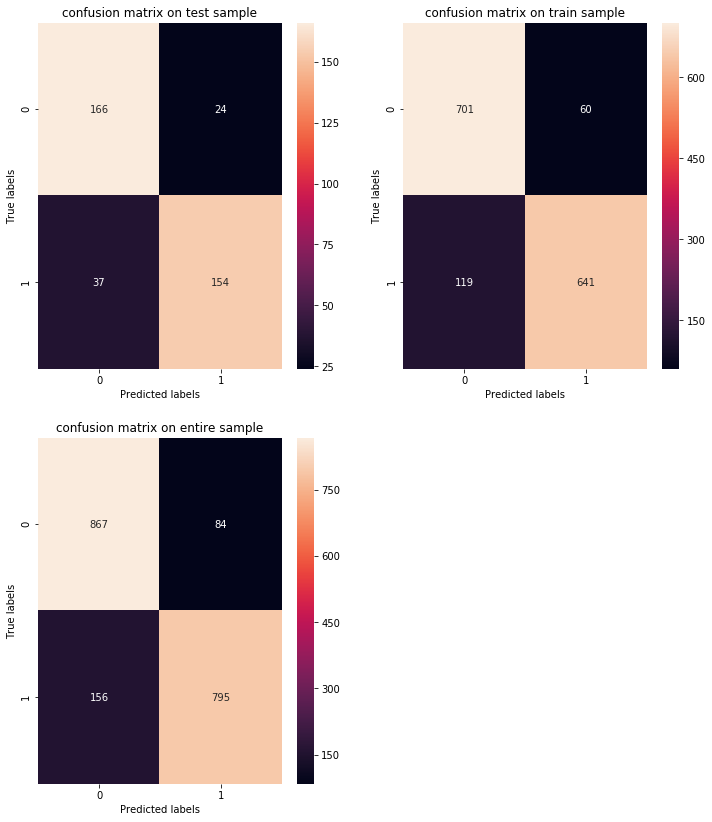

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(12,14))
fig.delaxes(ax[1,1])
    
matrix_3l_test = confusion_matrix(Y_test, Y_predict_3l_test.round())
matrix_3l_train = confusion_matrix(Y_train, Y_predict_3l_train.round())
matrix_3l = confusion_matrix(Y, Y_predict_3l.round())


ax = plt.subplot(2, 2, 1)
sns.heatmap(matrix_3l_test, annot=True, ax = ax, fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('confusion matrix on test sample');

ax = plt.subplot(2, 2, 2)
sns.heatmap(matrix_3l_train, annot=True, ax = ax, fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('confusion matrix on train sample'); 

ax = plt.subplot(2, 2, 3)
sns.heatmap(matrix_3l, annot=True, ax = ax, fmt='g'); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('confusion matrix on entire sample'); 


/usr/local/bin/start_ipykernel.py:8: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead


Text(0.5,0.98,'3 hidden layers 56,56,28 nodes')

<Figure size 1440x1440 with 0 Axes>

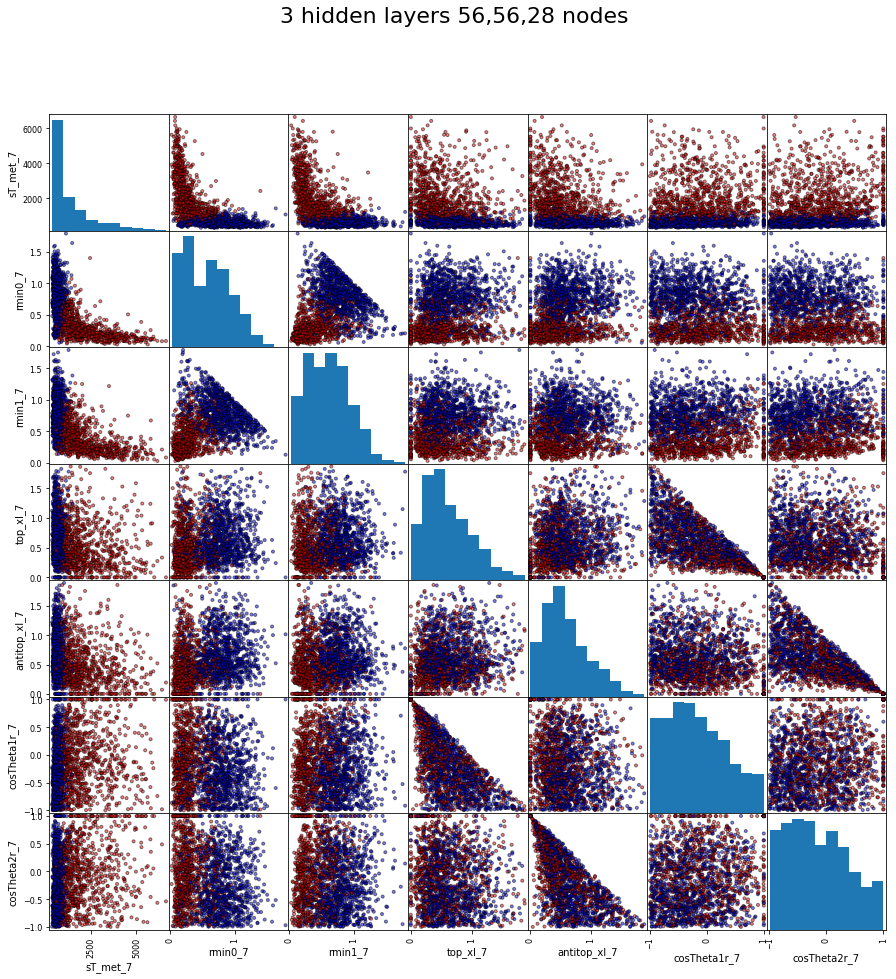

In [17]:
df_all['model_3l_predicted'] = model_3l.predict(X) # add prediction to array
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,20))
cm = plt.cm.bwr
cm_bright = ListedColormap(['#0000FF','#FF0000'])
pd.scatter_matrix(df_all[VARS],c=df_all['model_3l_predicted'], cmap=cm_bright
                  , edgecolors='k', figsize  = [15, 15])
plt.suptitle('3 hidden layers 56,56,28 nodes',fontsize=22)

In [18]:
def histogram_intersection(h1, h2):
    n1 = h1[0]
    n2 = h2[0]
    bins1 = h1[1]
    bins2 = h2[1]
    min_diff = 100
    intersect = 0    
    for i in range(1,len(n1)) :
        diff = abs(n1[i] - n2[i]);
        #print i, diff, min_diff, intersect
        if (diff < min_diff):
            min_diff = diff
            intersect = bins1[i-1] 

    return intersect  

intersection of bkg and sig predicted value 0.47368421052631576


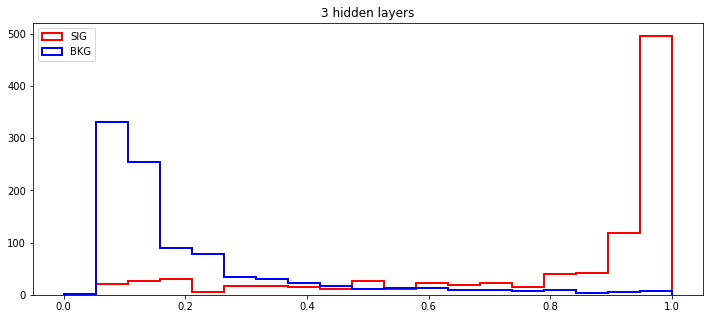

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax = plt.subplot(1, 1, 1)
binBoundaries = np.linspace(0,1.0,20)
h_sig = plt.hist(df_all[df_all['label'] == 1]["model_3l_predicted"], 
                  bins = np.linspace(0,1.0,20), label='SIG',histtype='step',lw=2, color='red')
h_bkg = plt.hist(df_all[df_all['label'] == 0]["model_3l_predicted"],
                  bins = np.linspace(0,1.0,20), label='BKG',histtype='step',lw=2, color='blue')

ax.legend(loc="upper left")
ax.title.set_text('3 hidden layers')   
cut = histogram_intersection(h_sig, h_bkg)
print "intersection of bkg and sig predicted value" , cut

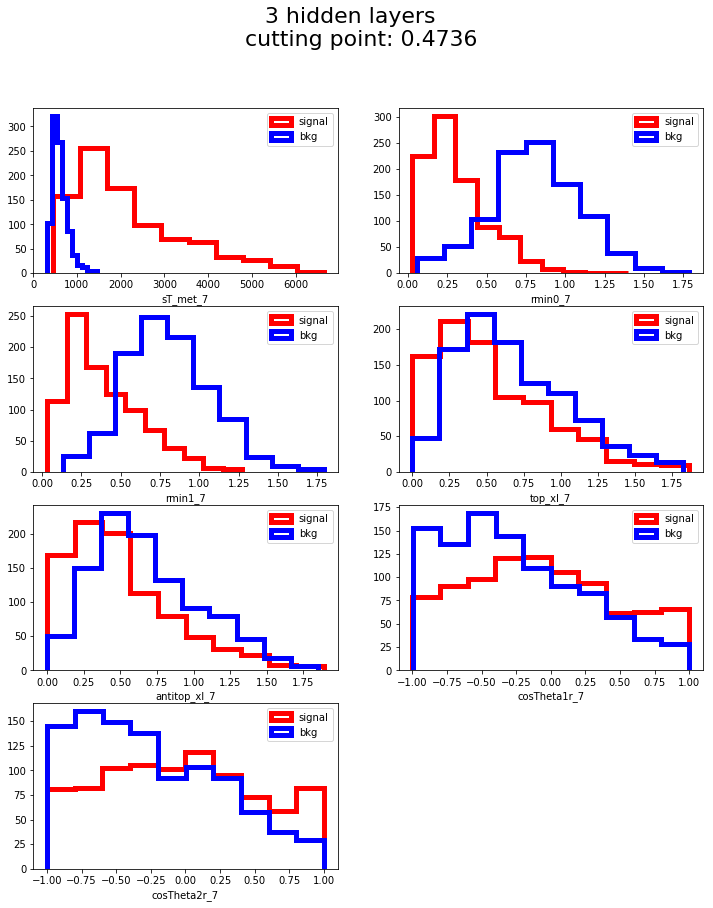

In [24]:
fig, ax = plt.subplots(int(math.ceil(len(VARS)/2.0)), 2, figsize=(12,14))
if len(VARS)%2 == 1 :  
    fig.delaxes(ax[int(math.ceil(len(VARS)/2.0))-1,1])
plt.suptitle('3 hidden layers  \n cutting point: 0.4736',fontsize=22)

for i in range(len(VARS)):
    ax = plt.subplot(int(math.ceil(len(VARS)/2.0)), 2, i+1)
    plt.hist( df_all[df_all['model_3l_predicted'] >= cut][VARS[i]],  histtype='step',linewidth=5,
             label='signal',color='red')
    plt.hist( df_all[df_all['model_3l_predicted'] < cut][VARS[i]],  histtype='step',linewidth=5,
             label='bkg',color='blue')    
    ax.set_xlabel(VARS[i])
    ax.legend(loc="upper right")